In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [26]:
train_set = np.load('FireEvac_train_set.npy')
test_set = np.load('FireEvac_test_set.npy')

num_sample = train_set.shape[0]
input_dim = train_set[0].shape[0]
w = h = int(np.sqrt(input_dim))

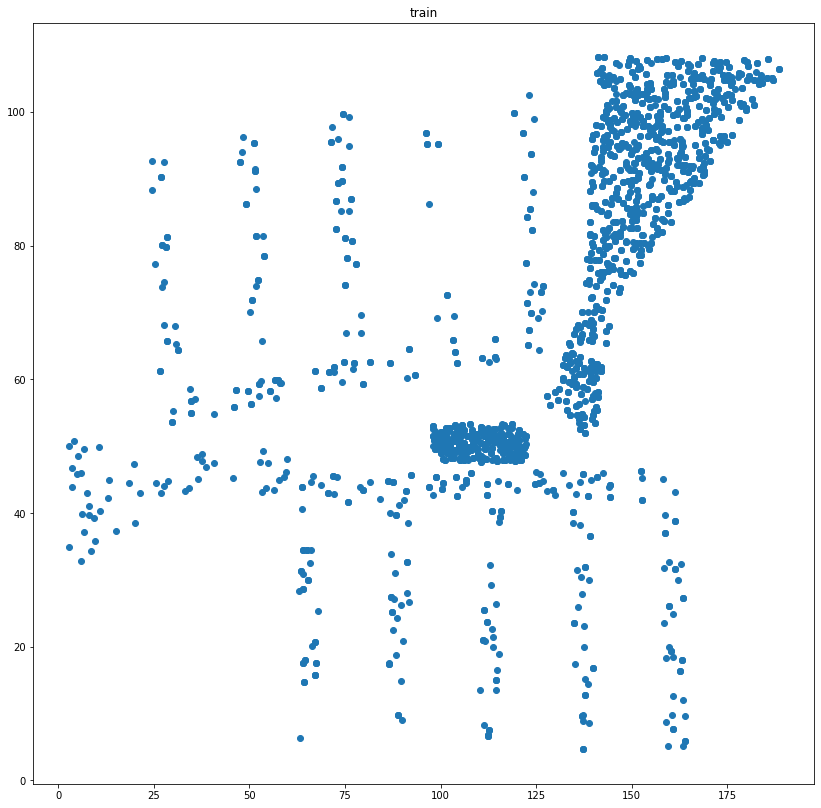

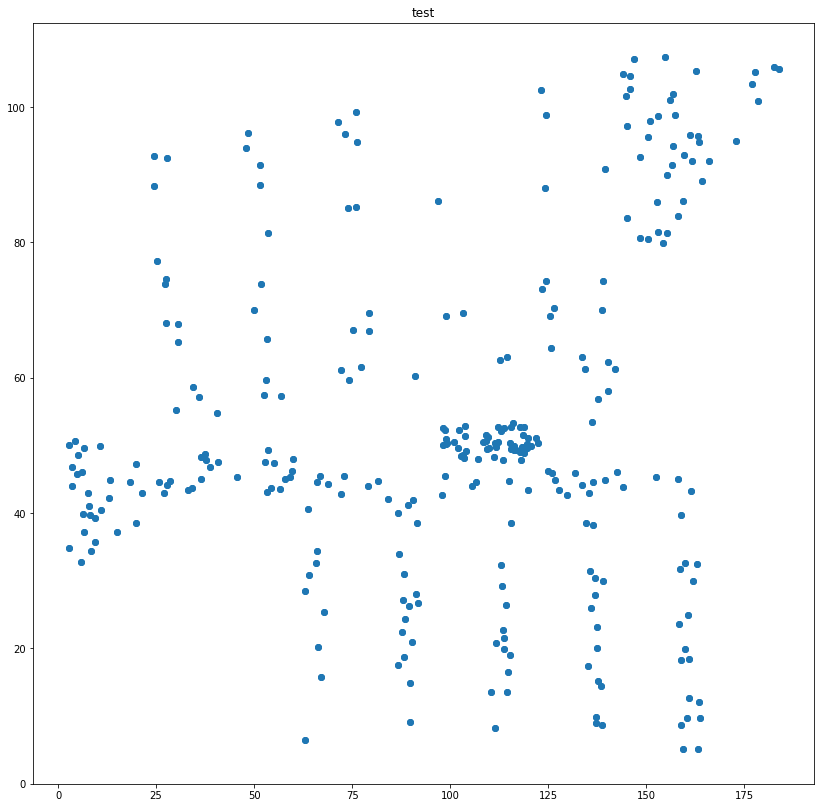

In [27]:
plt.figure(figsize = (14, 14))
plt.scatter((train_set)[:,0], (train_set)[:,1])
plt.title("train")

plt.show()

plt.figure(figsize = (14, 14))
plt.scatter((test_set)[:,0], (test_set)[:,1])
plt.title("test")

plt.show()

In [28]:
#normalize
x_max_train = np.amax(train_set[:,0])
y_max_train = np.amax(train_set[:,1])
x_max_test = np.amax(test_set[:,0])
y_max_test = np.amax(test_set[:,1])

train_set[:,0] /= x_max_train
train_set[:,1] /= y_max_train
test_set[:,0] /= x_max_test
test_set[:,1] /= y_max_test

In [20]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=256, n_z=2):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def build(self):
        tf.reset_default_graph()
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        #2 fc with relu activation functions for encoding
        f1 = fc(self.x, 128, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        
        #latent layer
        self.z_mu = fc(f2, self.n_z, scope='enc_fc3_mu', activation_fn=tf.nn.sigmoid)
        self.z_log_sigma_sq = fc(f2, self.n_z, scope='enc_fc3_sigma', activation_fn=tf.nn.sigmoid)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps
        
        #2 fc with activation function for decoding
        g1 = fc(self.z, 128, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        self.x_hat = fc(g2, input_dim, scope='dec_fc3', activation_fn=tf.nn.sigmoid)

        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), axis=1)
        self.recon_loss = tf.reduce_mean(recon_loss)

        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        #ELBO
        self.total_loss = 0.3*self.recon_loss + 0.7*self.latent_loss
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    def run_single_step(self, x):
        _, losses = self.sess.run([self.train_op, self.losses], feed_dict={self.x: x})
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [21]:
def trainer(model_class, learning_rate=1e-3, batch_size=1024, num_epoch=5, n_z=2, log_step=10):
    model = model_class(learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    elbo = []
    recon = []
    latent = []
    for epoch in range(num_epoch):
        start_time = time.time()
        
        for iter in range(num_sample // batch_size):
            
            batch_index = np.random.randint(3000-batch_size)
            batch = train_set[batch_index : batch_index+batch_size]
            losses = model.run_single_step(batch)
            
        end_time = time.time()
        elbo.append(losses["total_loss"])
        recon.append(losses["recon_loss"])
        latent.append(losses["latent_loss"])
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')

    plt.figure(figsize = (12, 12)) 
    plt.plot([e for e in range(num_epoch)], elbo, label = "ELBO")
    plt.plot([e for e in range(num_epoch)], recon, label = "Reconstruction Loss")
    plt.plot([e for e in range(num_epoch)], latent, label = "Latent Loss")
    plt.title("EPOCH VS ELBO")
    plt.legend()

    plt.show()
    
    return model

In [22]:
def test_reconstruction(model, test_set, h=2, w=2):

    batch = test_set
    x_reconstructed = model.reconstructor(batch)
    
    x_reconstructed[:,0] *= x_max_test
    x_reconstructed[:,1] *= y_max_test

    plt.figure(figsize = (14, 14))
    plt.scatter((x_reconstructed)[:,0], (x_reconstructed)[:,1])
    plt.title("x_reconstructed")

    plt.show()

In [23]:
def test_generation(model, z=None, h=2, w=2, batch_size=1000, plot=True):

    if z is None:
        z = np.random.normal(size=[batch_size, model.n_z])
    x_generated = model.generator(z)
    
    x_generated[:,0] *= x_max_test
    x_generated[:,1] *= y_max_test
    
    if plot:
        plt.figure(figsize = (14, 14))
        plt.scatter((x_generated)[:,0], (x_generated)[:,1])
        plt.title("x_generated")
        plt.show()
    return x_generated

dim=2 epoch=50
[Epoch 0] recon_loss: 1.254  latent_loss: 6.360  total_loss: 4.828  (0.047 sec/epoch)
[Epoch 10] recon_loss: 1.252  latent_loss: 3.905  total_loss: 3.109  (0.022 sec/epoch)
[Epoch 20] recon_loss: 1.190  latent_loss: 0.453  total_loss: 0.674  (0.028 sec/epoch)
[Epoch 30] recon_loss: 1.226  latent_loss: 0.033  total_loss: 0.391  (0.023 sec/epoch)
[Epoch 40] recon_loss: 1.216  latent_loss: 0.009  total_loss: 0.371  (0.020 sec/epoch)
[Epoch 50] recon_loss: 1.178  latent_loss: 0.004  total_loss: 0.356  (0.021 sec/epoch)
[Epoch 60] recon_loss: 1.184  latent_loss: 0.003  total_loss: 0.357  (0.023 sec/epoch)
[Epoch 70] recon_loss: 1.179  latent_loss: 0.002  total_loss: 0.355  (0.029 sec/epoch)
[Epoch 80] recon_loss: 1.178  latent_loss: 0.001  total_loss: 0.354  (0.034 sec/epoch)
[Epoch 90] recon_loss: 1.215  latent_loss: 0.001  total_loss: 0.365  (0.022 sec/epoch)
Done!


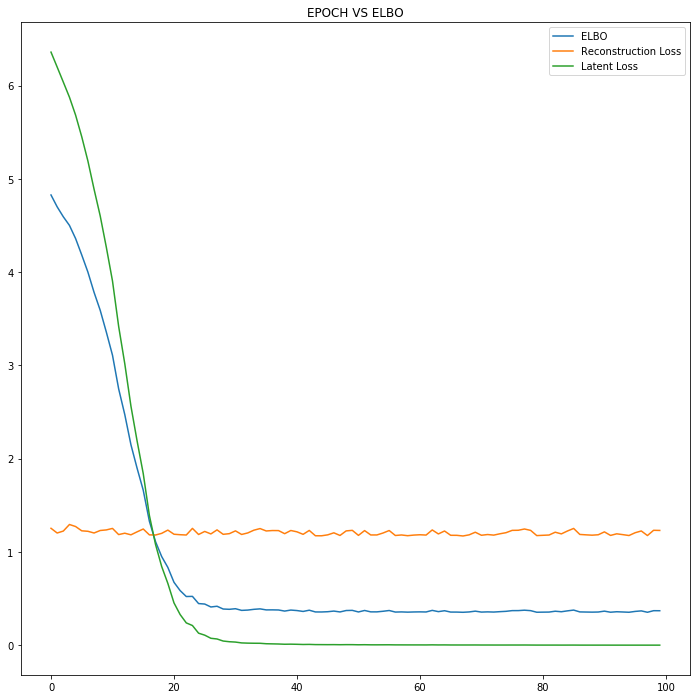

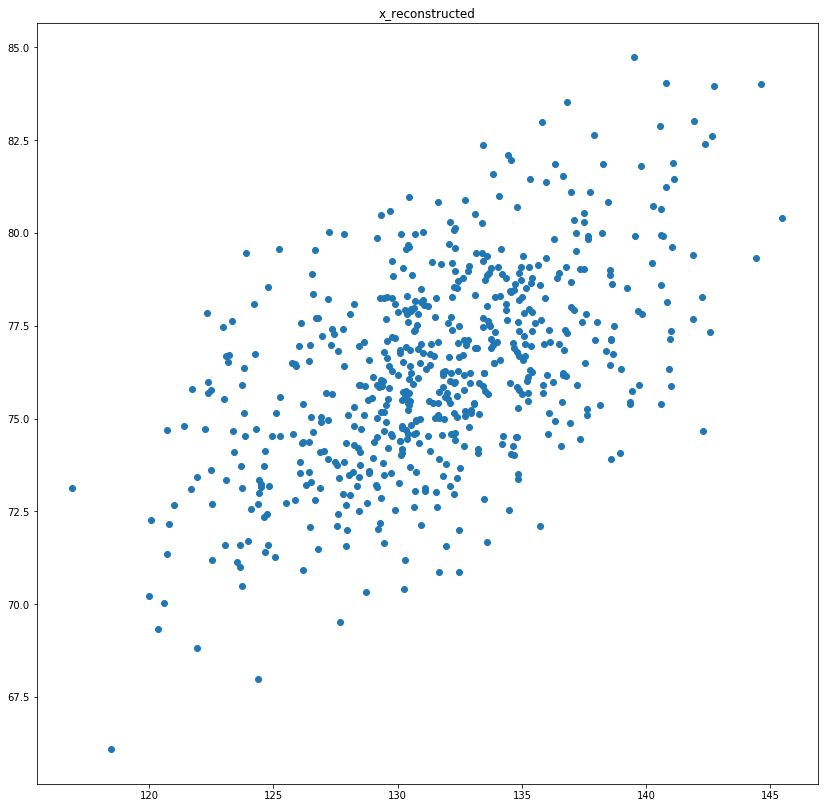

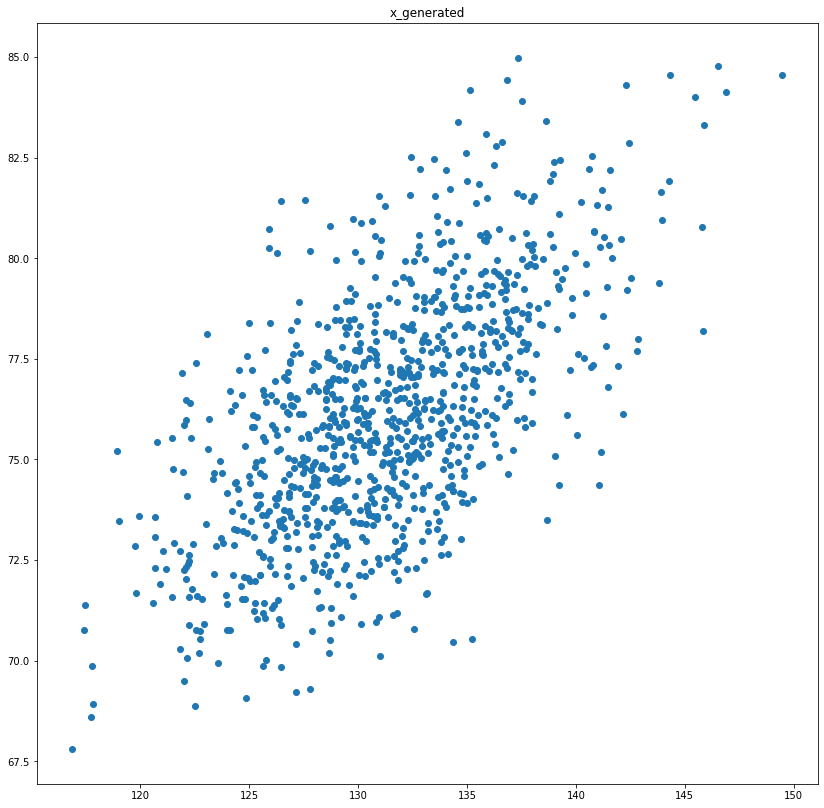

array([[128.43823 ,  73.79517 ],
       [137.43481 ,  78.26599 ],
       [126.812706,  73.69281 ],
       ...,
       [129.42111 ,  72.980995],
       [124.91865 ,  77.574974],
       [122.42835 ,  72.887474]], dtype=float32)

In [24]:
print("dim=2 epoch=50")
model_vae = trainer(VariantionalAutoencoder, n_z=32, num_epoch=100)
test_reconstruction(model_vae, test_set)
test_generation(model_vae)

2227
1006


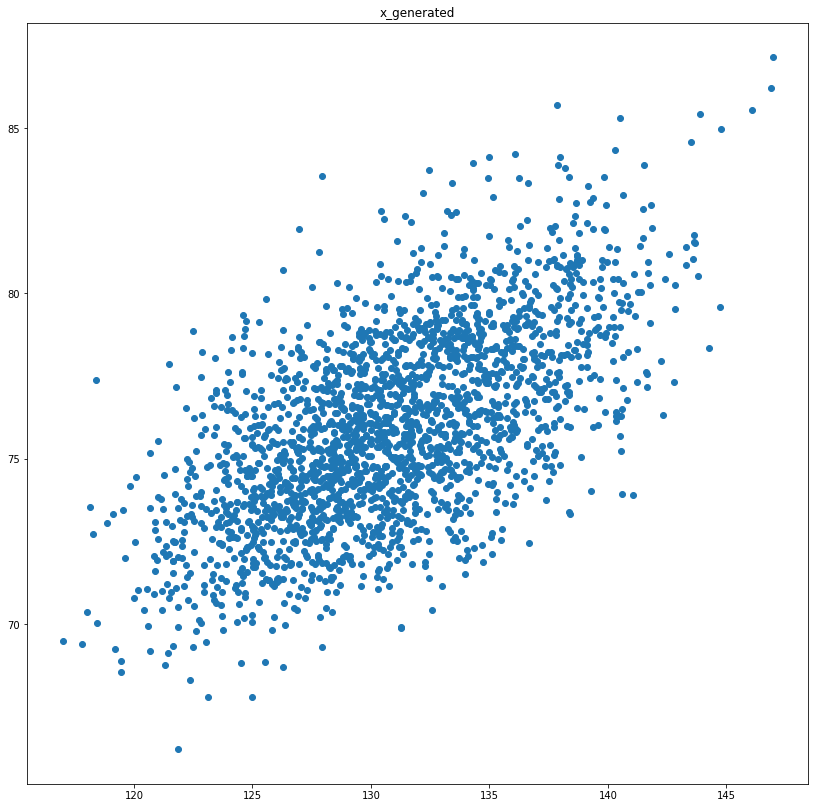

In [25]:
num_people = 10
counter = 0

while counter < 1000:
    num_people += 1
    x_hat = test_generation(model_vae, batch_size=num_people, plot=False)
    counter = 0
    for i in range(num_people):
        if ((130 > x_hat[i][0] and x_hat[i][0] > 70) and (150 > x_hat[i][1] and x_hat[i][1] > 50)):
            counter += 1

print(num_people)
print(counter)
plt.figure(figsize = (14, 14))
plt.scatter((x_hat)[:,0], (x_hat)[:,1])
plt.title("x_generated")
plt.show()

In [ ]:
#2:2:2 = 1079 / 1.399
#2:4:2 = 1386 / 1.5
#4:8:4 == 1103 / 1.393